In [1]:
import datetime
import logging
import os
import subprocess
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import tensorflow as tf
from sklearn.model_selection import train_test_split

import pugna.data
import pugna.layers
import pugna.activations

%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({"font.size": 16})



In [2]:
# get my pugna logger
# https://gitlab.com/SpaceTimeKhantinuum/pugna/-/blob/master/pugna/logger.py
def init_logger(level=0):
    """setup logging

    Keyword Arguments:
        level {int} -- either 0, 1 or 2. (default: {0})
            0: WARNING
            1: INFO
            2: DEBUG

    Returns:
        logger -- logger object
    """
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")

    # need to do this to avoid print things twice
    # https://stackoverflow.com/a/6729713/12840171
    # and this to setup levels
    # https://stackoverflow.com/questions/14097061/easier-way-to-enable-verbose-logging
    if not logger.handlers:
        handler = logging.StreamHandler(sys.stdout)
        handler.flush = sys.stdout.flush
        if level == 0:
            handler.setLevel(logging.WARNING)
        elif level == 1:
            handler.setLevel(logging.INFO)
        elif level == 2:
            handler.setLevel(logging.DEBUG)
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    else:
        logger.handlers[0].formatter = formatter
        if level == 0:
            logger.setLevel(logging.WARNING)
        elif level == 1:
            logger.setLevel(logging.INFO)
        elif level == 2:
            logger.setLevel(logging.DEBUG)
        logger.handlers[0].flush()

    return logger

In [3]:
def download_and_load_data():
    if os.path.exists("scaled_data_to_fit.txt") is False:
        os.system(
            "curl https://gitlab.com/SpaceTimeKhantinuum/ml/-/raw/master/nn-fitting/1d-fitting/scaled_data_to_fit.txt -O "
        )

    Xy = np.loadtxt("scaled_data_to_fit.txt")
    # sort by X
    X_raw, y_raw = Xy[np.argsort(Xy[:, 0])].T

    return X_raw, y_raw

In [4]:
def resample_data(X, y, xmin=None, xmax=None, npts=1000, k=1):

    if xmin is None:
        xmin = X[0]
    if xmax is None:
        xmax = X[-1]
    mask = (X >= xmin) & (X <= xmax)

    iy = IUS(X[mask], y[mask], k=k)

    Xnew = np.linspace(xmin, xmax, npts)

    return Xnew, iy(Xnew)

In [5]:
logger = init_logger(level=2)
logger.info("test")
starttime = datetime.datetime.now()

# set_threads()

# check_gpu()

x, y = download_and_load_data()

x, y = resample_data(x, y, xmin=None, xmax=None, npts=150, k=1)
#x, y = resample_data(x, y, xmin=None, xmax=None, npts=500, k=1)
#x, y = resample_data(x, y, xmin=None, xmax=None, npts=1000, k=1)
#x, y = resample_data(x, y, xmin=None, xmax=None, npts=5000, k=1)
#x, y = resample_data(x, y, xmin=None, xmax=None, npts=10000, k=1)
# x, y = resample_data(x, y, xmin=None, xmax=None, npts=50000, k=1)

x = x[:, np.newaxis]
y = y[:, np.newaxis]

# split and shuffle data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# check shapes
names = ["X_train", "X_test", "y_train", "y_test"]
for k, v in enumerate([X_train, X_test, y_train, y_test]):
    logger.info(f"{names[k]}.shape:  {v.shape}")


2020-11-06 17:16:21,907 - INFO - test
2020-11-06 17:16:21,962 - INFO - X_train.shape:  (112, 1)
2020-11-06 17:16:21,963 - INFO - X_test.shape:  (38, 1)
2020-11-06 17:16:21,963 - INFO - y_train.shape:  (112, 1)
2020-11-06 17:16:21,964 - INFO - y_test.shape:  (38, 1)


In [6]:
units = 1000
nscales = 10
lr = 0.001

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
model.add(pugna.layers.Mscale(units, nscales))
model.add(tf.keras.layers.Activation(pugna.activations.s2relu))
model.add(pugna.layers.Mscale(units, nscales))
model.add(tf.keras.layers.Activation(pugna.activations.s2relu))
model.add(tf.keras.layers.Dense(1, activation="linear"))

#optimizer = tf.keras.optimizers.Adam(lr)
optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True)
#optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipnorm=0.5)
#optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipvalue=5.0)
#optimizer = tf.keras.optimizers.Nadam(lr)
# optimizer = tf.keras.optimizers.SGD(lr)
model.compile(loss="mse", optimizer=optimizer)

In [8]:
batch_size = X_train.shape[0]
epochs = 100

In [9]:
%%time
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=False)

CPU times: user 3.09 s, sys: 879 ms, total: 3.97 s
Wall time: 1.03 s


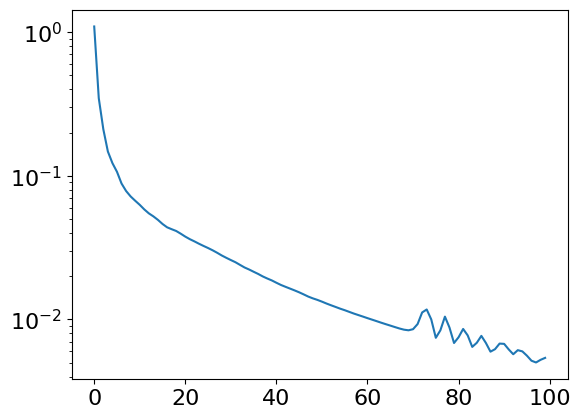

In [10]:
loss = history.history["loss"]
plt.figure()
plt.plot(range(len(loss)), loss)
plt.yscale("log")
plt.show()

In [11]:
plt.figure()
plt.scatter(X_train, y_train)
plt.scatter(X_train, model.predict(X_train), marker='x')
plt.show()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mscale_1 (Mscale)            (None, 1000)              2000      
_________________________________________________________________
activation (Activation)      (None, 1000)              0         
_________________________________________________________________
mscale_3 (Mscale)            (None, 1000)              1001000   
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 1,004,001
Trainable params: 1,004,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
import pugna.model_utils

In [14]:
pugna.model_utils.save_model_json(model, "test_mscale_model")

In [15]:
pugna.model_utils.save_model_h5(model, "test_mscale_model")

In [16]:
new_model = pugna.model_utils.load_model_h5("test_mscale_model.h5",
                                custom_objects={'Mscale': pugna.layers.Mscale, 
                                               's2relu':pugna.activations.s2relu})

In [17]:
print(new_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mscale_4 (Mscale)            (None, 1000)              2000      
_________________________________________________________________
activation (Activation)      (None, 1000)              0         
_________________________________________________________________
mscale_5 (Mscale)            (None, 1000)              1001000   
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 1,004,001
Trainable params: 1,004,001
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
new_model = pugna.model_utils.load_model_json("test_mscale_model",
                                custom_objects={'Mscale': pugna.layers.Mscale, 
                                               's2relu':pugna.activations.s2relu})

In [19]:
print(new_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mscale_6 (Mscale)            (None, 1000)              2000      
_________________________________________________________________
activation (Activation)      (None, 1000)              0         
_________________________________________________________________
mscale_7 (Mscale)            (None, 1000)              1001000   
_________________________________________________________________
activation_1 (Activation)    (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 1,004,001
Trainable params: 1,004,001
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
model.predict(X_train)-new_model.predict(X_train)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [21]:
plt.figure()
plt.scatter(X_train, model.predict(X_train)-new_model.predict(X_train), marker='x')
plt.show()

In [22]:
# help from

# https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers

# and

# https://stackoverflow.com/questions/62169315/runtimeerror-unable-to-create-link-name-already-exists-keras